**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/time-series-as-features).**

---


# Introduction #

Run this cell to set everything up!

In [1]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('./data/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

In [2]:
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [3]:
# just 2017
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

----------------------------------------------------------------------------

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely *cyclic* behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize *Supply Sales*. We'll store the result in a variable `y_deseason`.

In [4]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
y.head()

date
2017-01-01    0.000000
2017-01-02    2.925926
2017-01-03    2.018518
2017-01-04    1.722222
2017-01-05    1.425926
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, dtype: float32

Create in-sample values using both seasonal indicators and Fourier features.

In [5]:
# order 4 for weeks in month
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1, # trend
    seasonal=True, # indicators for day of week (minus first day, so it can be predicted)
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

X_time.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False


Model and predict both y and y_deseason.

y_pred RMSLE: 1.18549
y_deseason RMSLE: 1.00153


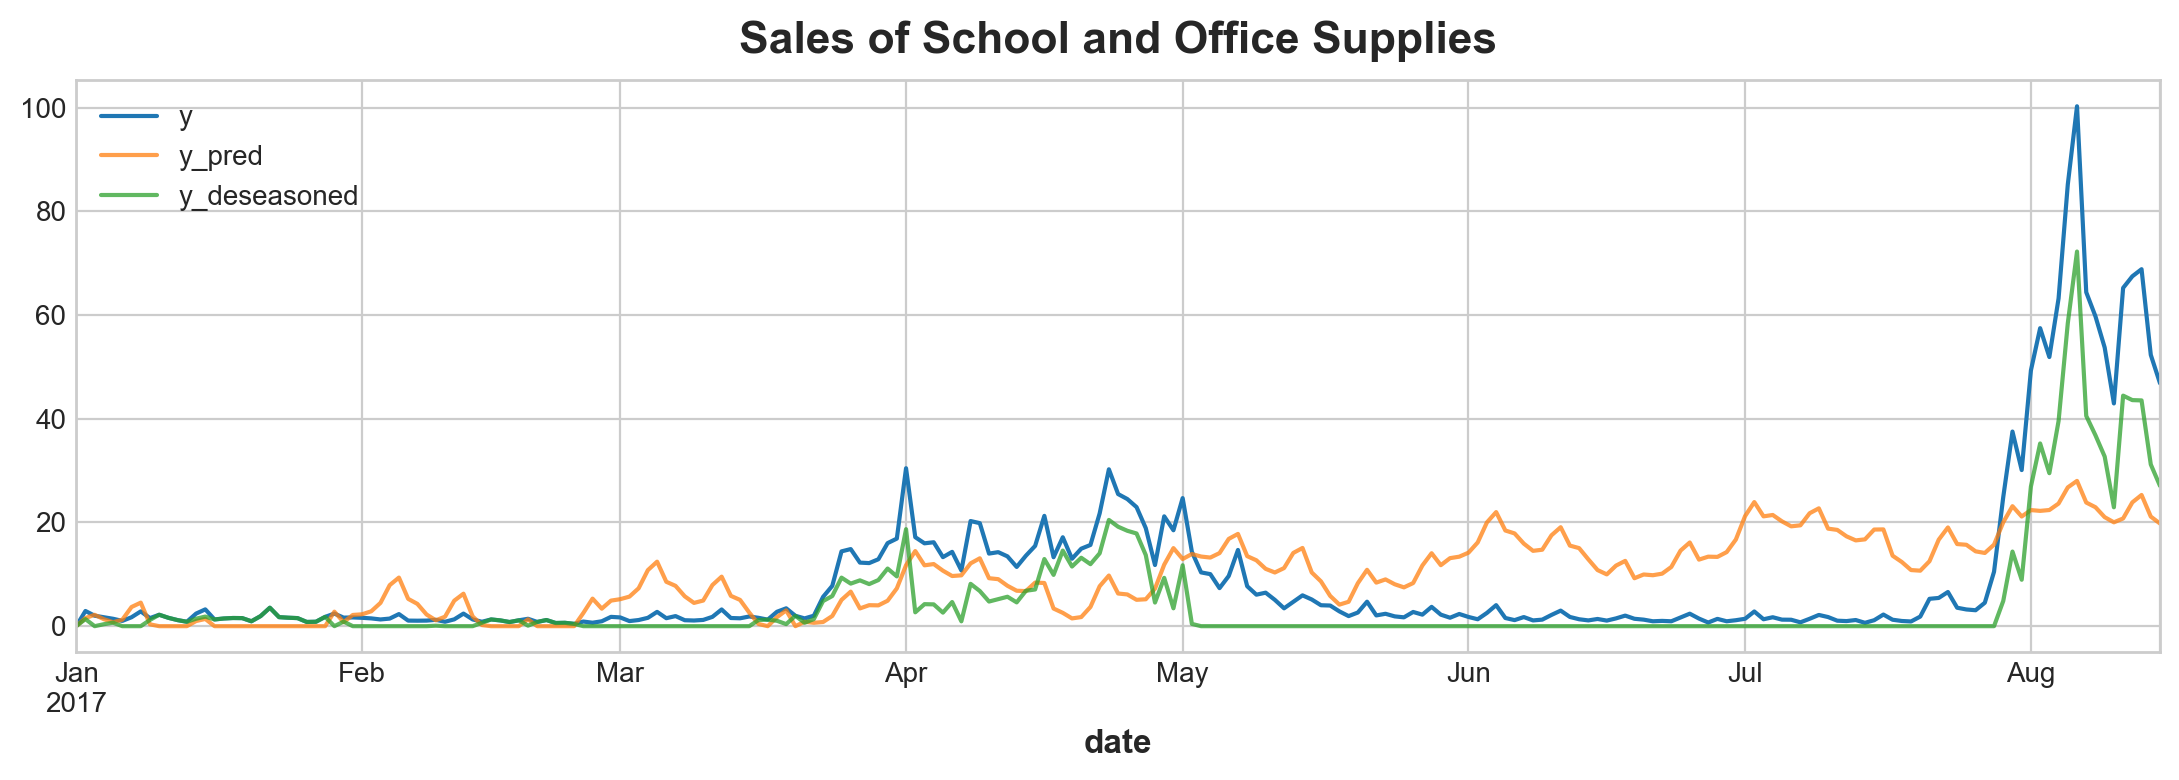

In [6]:
model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)

y_pred = pd.Series(model.predict(X_time), index=y.index)

# set all negative values to zero else RMSLE fails
y_pred[y_pred < 0] = 0
rmsle = mean_squared_log_error(y, y_pred) ** 0.5
print(f'y_pred RMSLE: {rmsle:.5f}')

y_deseason = y - y_pred
y_deseason.name = 'sales_deseasoned'

# set all negative values to zero else RMSLE fails
y_deseason[y_deseason < 0] = 0
rmsle = mean_squared_log_error(y, y_deseason) ** 0.5
print(f'y_deseason RMSLE: {rmsle:.5f}')

ax = y.plot(label="y")
ax = y_pred.plot(ax=ax, label="y_pred", alpha=0.75)
ax = y_deseason.plot(label="y_deseasoned", alpha=0.75)
ax.set_title("Sales of School and Office Supplies")
_ = ax.legend()

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

# 1) Plotting cycles

Create a seven-day moving average from `y`, the series of supply sales. Use a centered window, but don't set the `min_periods` argument.

7-day moving average RMSLE: 0.53313


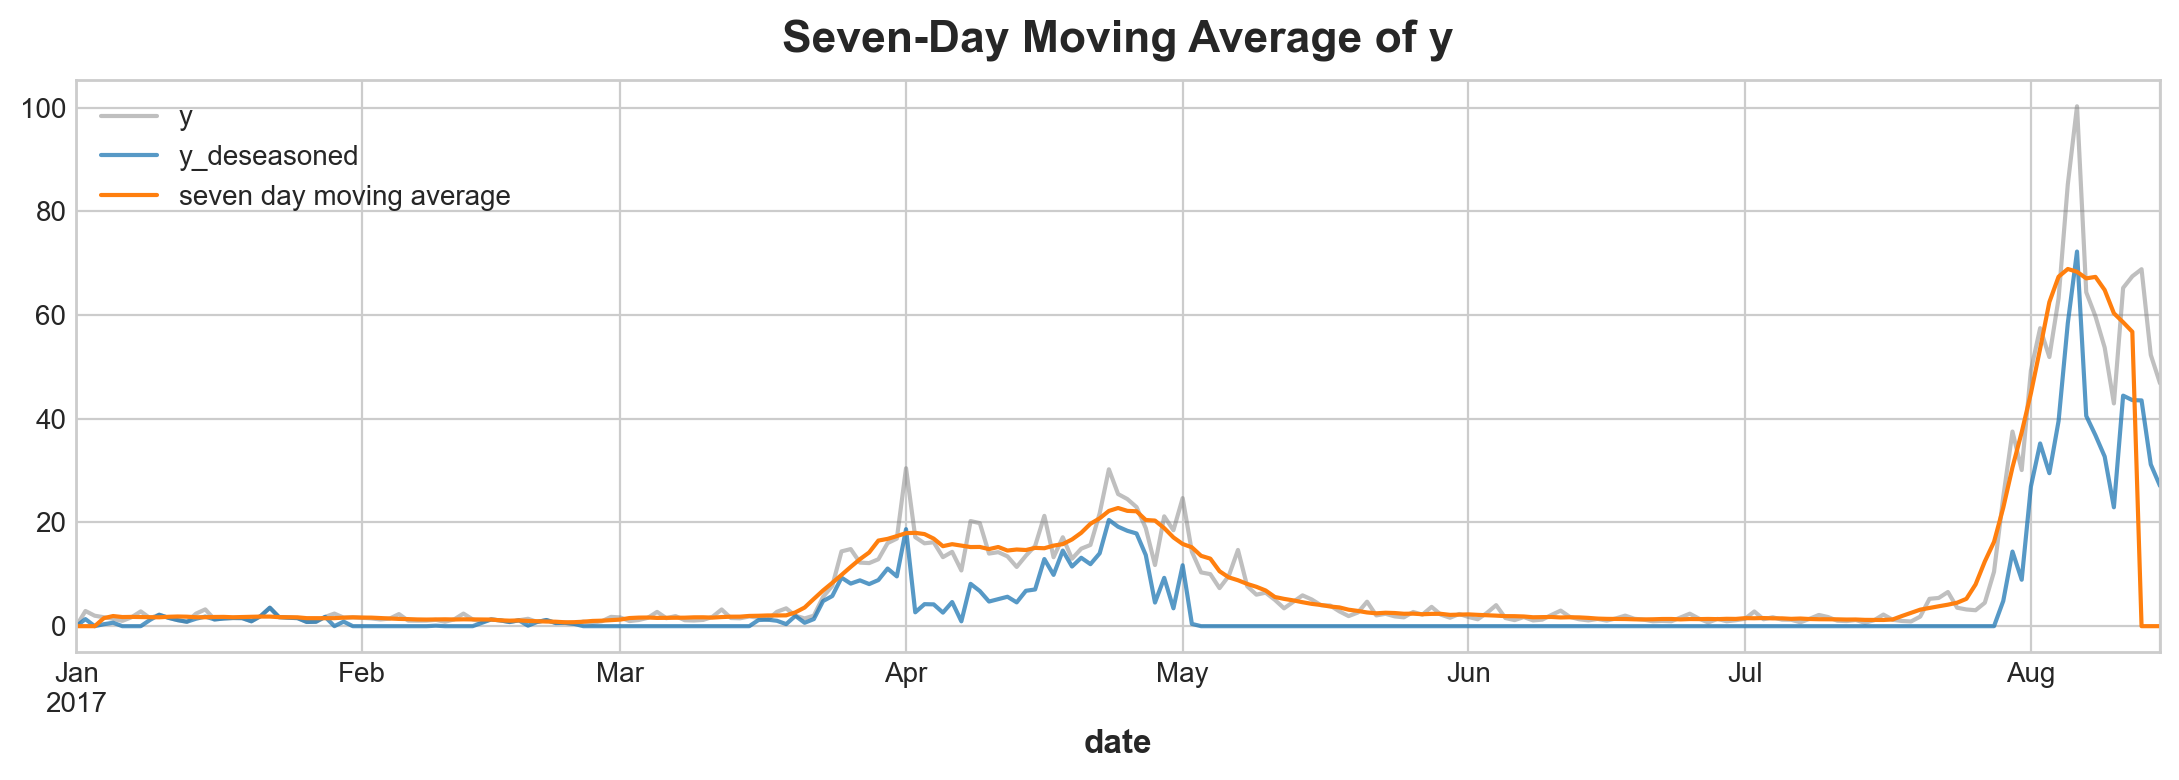

In [7]:
# seven day moving average of supply sales
y_ma = y.rolling(
    window=7,         # 7-day window
    center=True,      # puts the average at the center of the window
).mean().fillna(0) 

rmsle = mean_squared_log_error(y, y_ma) ** 0.5
print(f'7-day moving average RMSLE: {rmsle:.5f}')

# Plot
ax = y.plot(style="-", color="0.5", label="y", alpha=0.5)
ax = y_deseason.plot(label="y_deseasoned", alpha=0.75)
ax = y_ma.plot(label="seven day moving average")
ax.set_title("Seven-Day Moving Average of y")
_ = ax.legend()

Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

-------------------------------------------------------------------------------

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

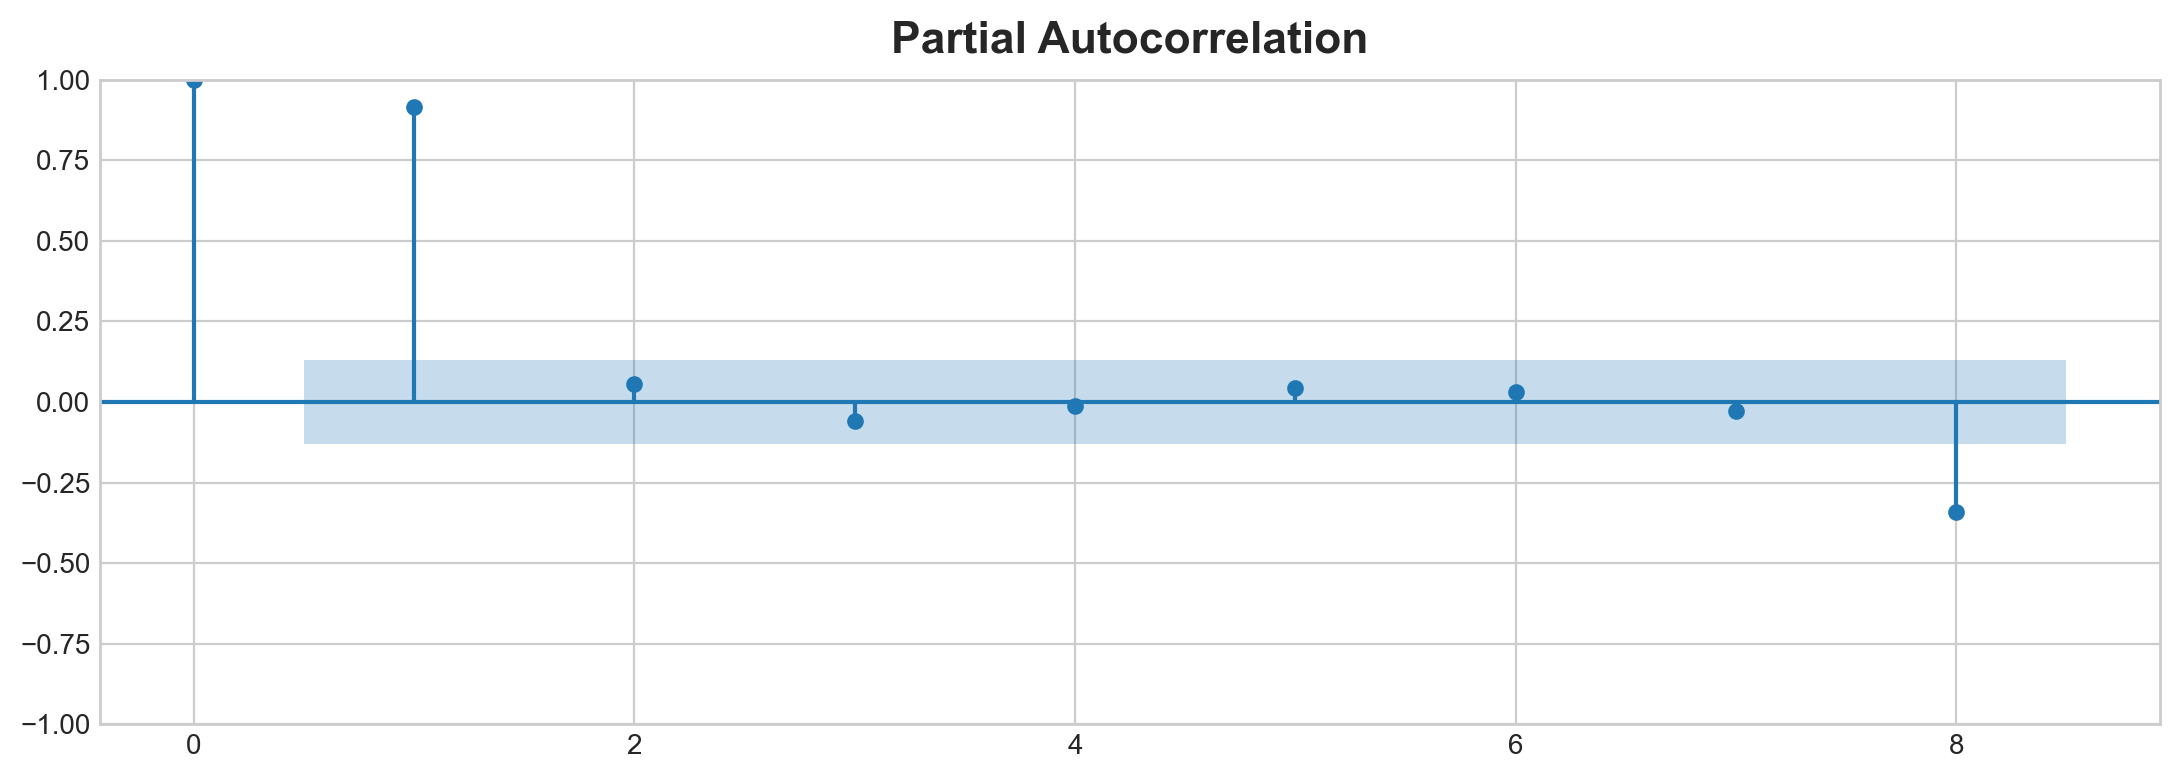

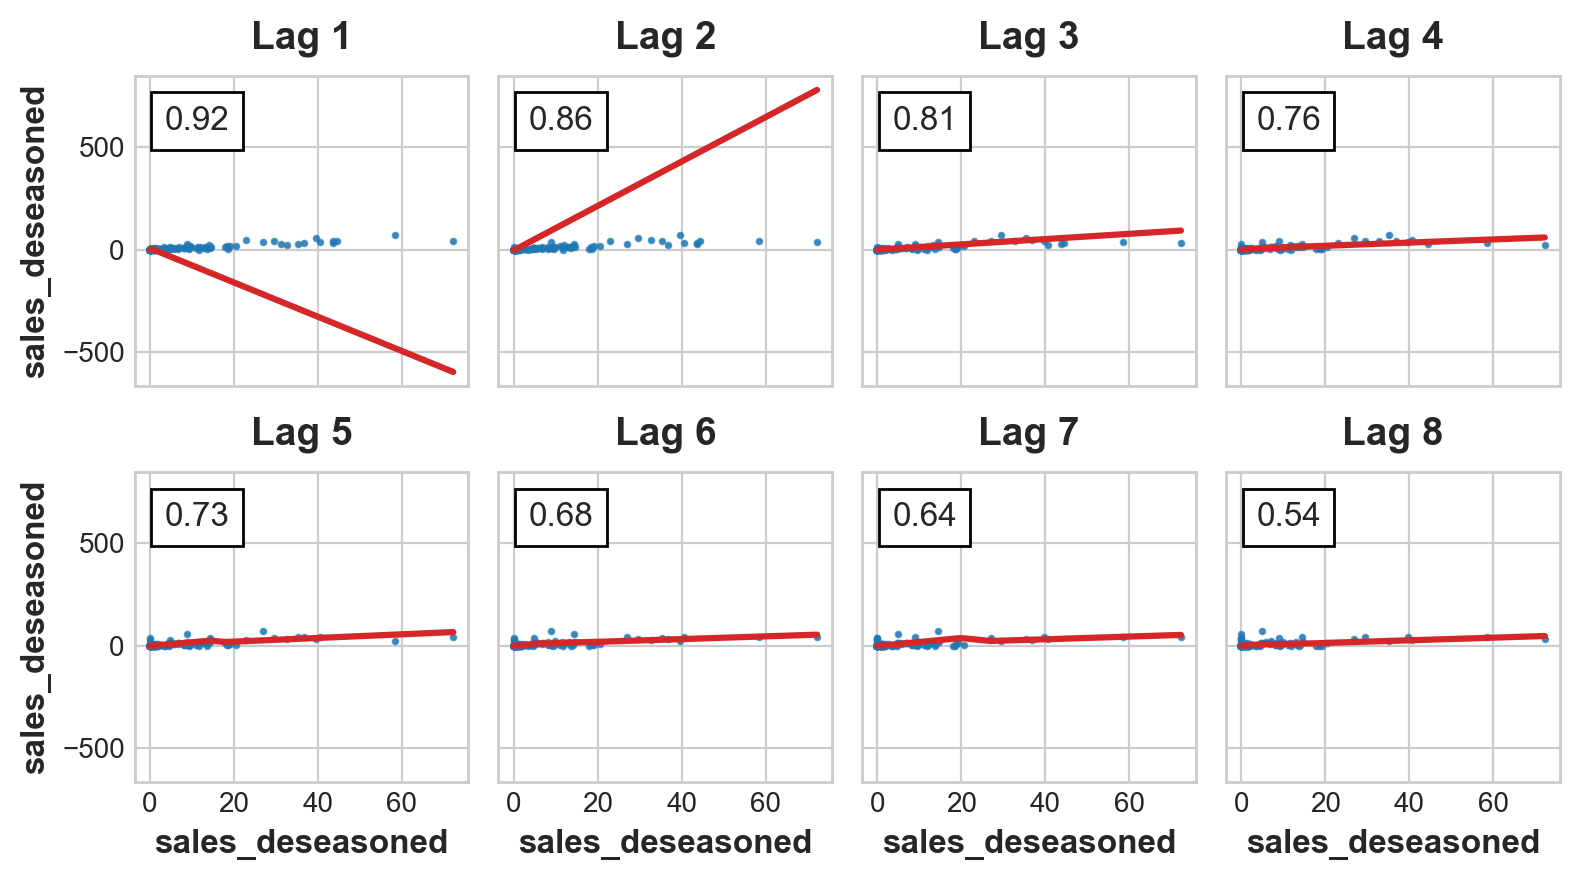

In [8]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

# 2) Examine serial dependence in *Store Sales*

Are any of the lags significant according to the correlogram? Does the lag plot suggest any relationships that weren't apparent from the correlogram?

The lag plots show linearity in all lags. The correlogram shows significance in lags 1 and 8.

-------------------------------------------------------------------------------

Recall from the tutorial that a *leading indicator* is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for `onpromotion` plotted against sales of school and office supplies.

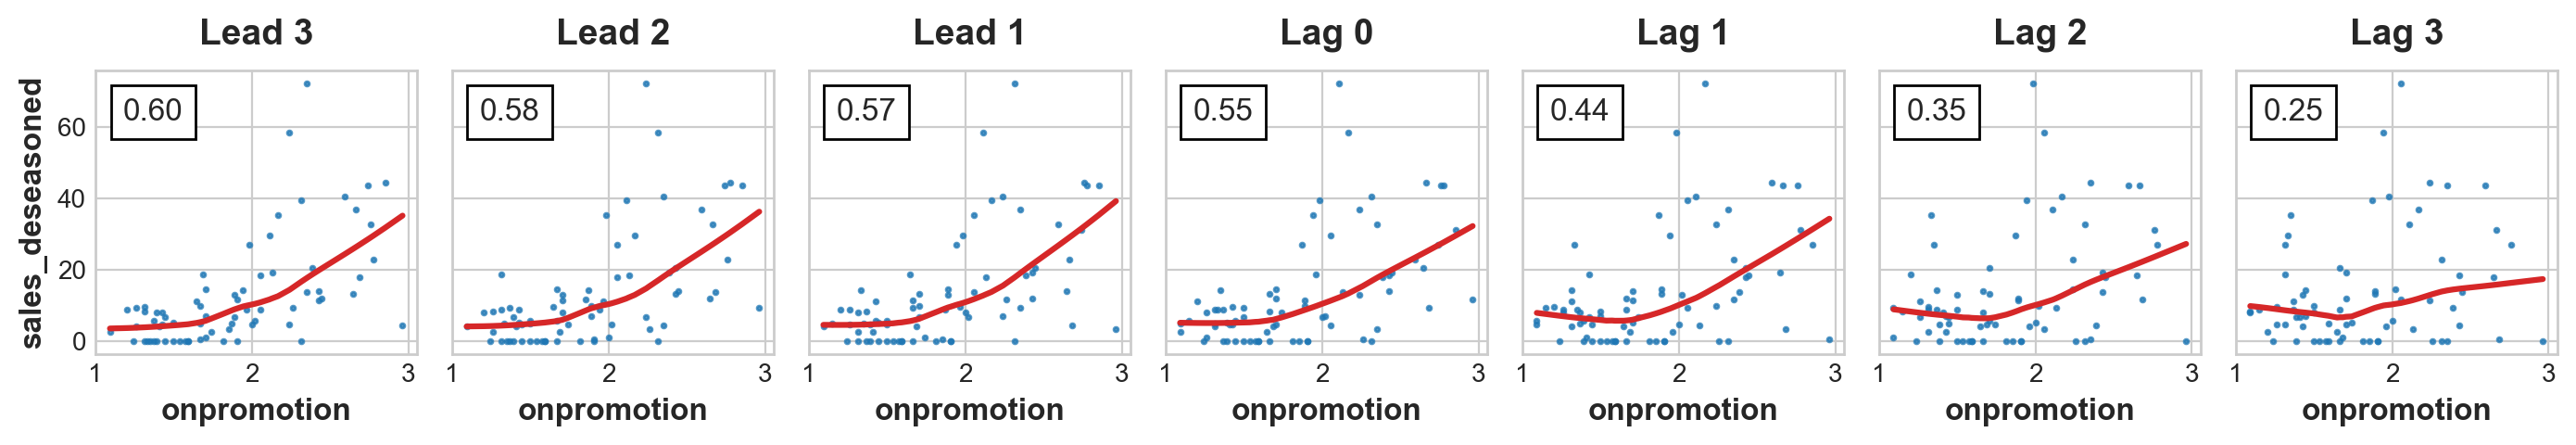

In [9]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], 
          y=y_deseason.loc[onpromotion > 1], 
          lags=3, leads=3, nrows=1);

# 3) Examine time series features

Does it appear that either leading or lagging values of `onpromotion` could be useful as a feature?

Lag 1 (leading and lagging) and to a lesser degree lag 2 (leading and lagging) look to be useful as features.

The lag plot indicates that both leading and lagged values of `onpromotion` are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

-------------------------------------------------------------------------------

# 4) Create time series features

Create the features indicated in the solution to Question 3. If no features from that series would be useful, use an empty dataframe `pd.DataFrame()` as your answer.

In [10]:
# Make features from `y_deseason`
X_lags = make_lags(y_deseason, lags=8, name='deseason')

# Make features from `onpromotion` using lagging and leading features
X_promo = pd.concat([
    make_lags(onpromotion, lags=2),
    onpromotion,
    make_leads(onpromotion, leads=2),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).fillna(0)
y, X = y.align(X, join='inner')

X.head(1)

,deseason_lag_1,deseason_lag_2,deseason_lag_3,deseason_lag_4,deseason_lag_5,deseason_lag_6,deseason_lag_7,deseason_lag_8,y_lag_1,y_lag_2,onpromotion,y_lead_1,y_lead_0
date,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use the code in the next cell if you'd like to see predictions from the resulting model.

Training RMSE: 2.22076
Validation RMSE: 20.67268
Training RMSLE: 0.70859
Validation RMSLE: 0.96426


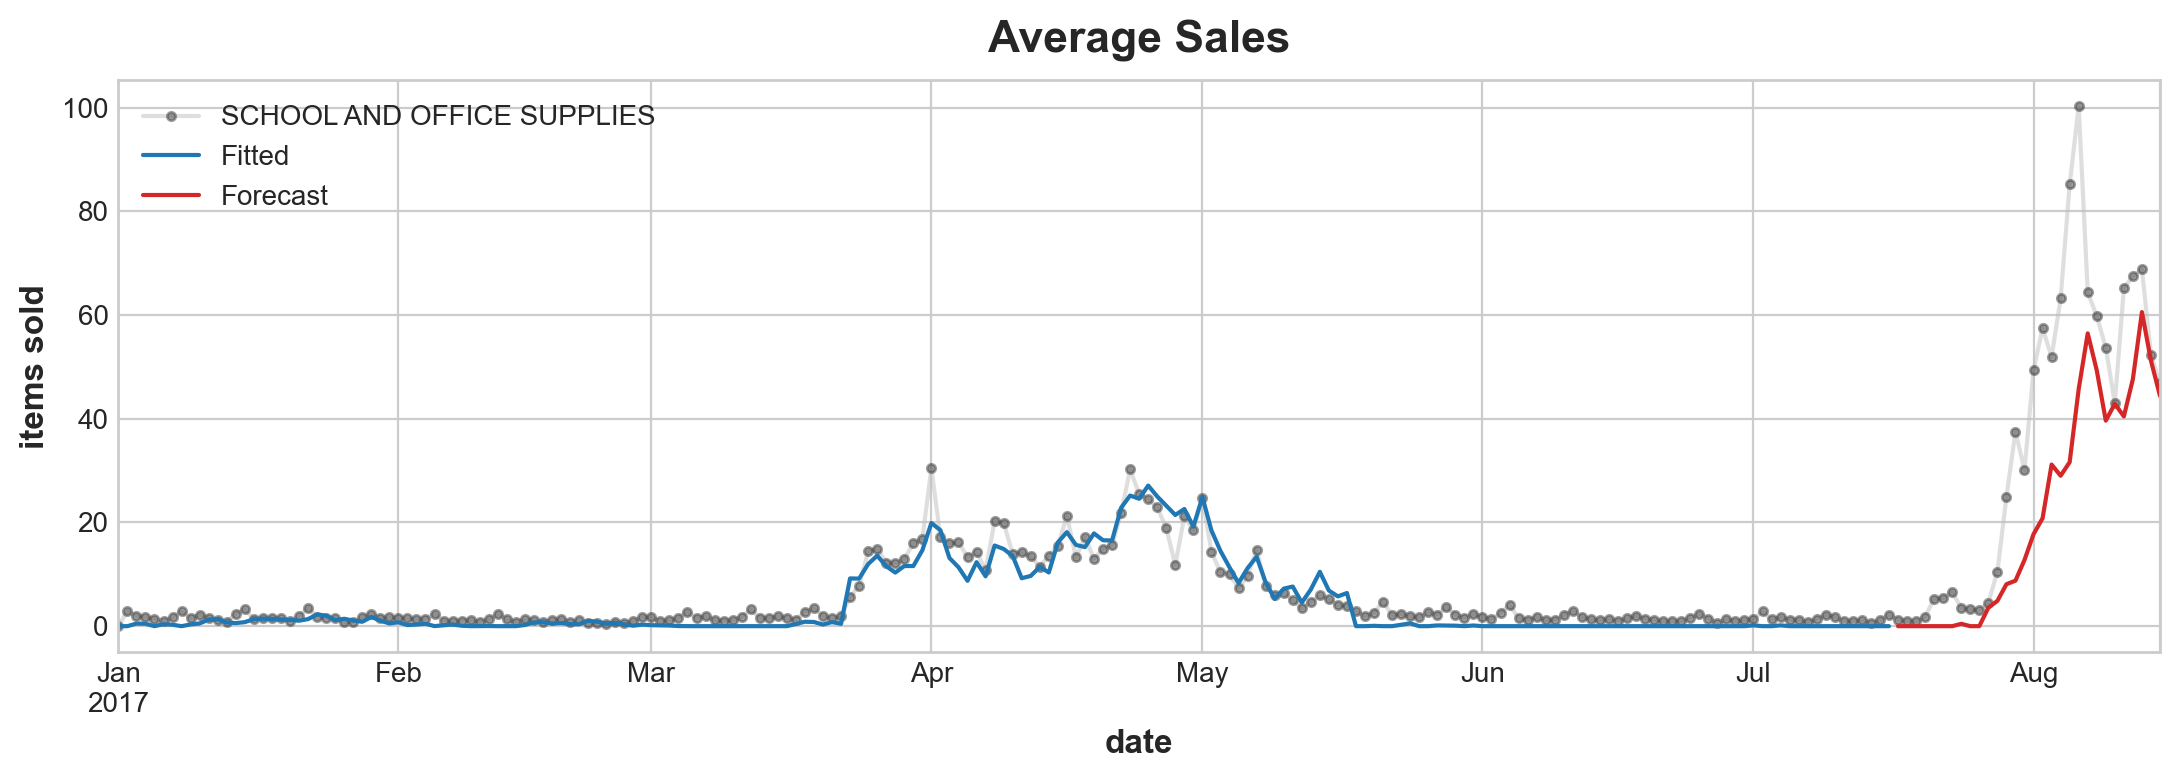

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

# RMSE
rmse_train = mean_squared_error(y_train, y_fit, squared=False)
rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Training RMSE: {rmse_train:.5f}')
print(f'Validation RMSE: {rmse_valid:.5f}')

# RMSLE
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

-------------------------------------------------------------------------------

Winners of Kaggle forecasting competitions have often included moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

In Lesson 2 you learned how to compute moving averages to estimate trends. Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the `rolling` method. Second, the target should be lagged a step.

# 5) Create statistical features

Edit the code in the next cell to create the following features:
- 14-day rolling median (`median`) of lagged target
- 7-day rolling standard deviation (`std`) of lagged target
- 7-day sum (`sum`) of items "on promotion", with centered window

In [12]:
y_lag = supply_sales.loc[:, 'sales'].shift(1).fillna(0)
onpromo = supply_sales.loc[:, 'onpromotion']

# 7-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()

# replace missing values
mean_7.fillna(0, inplace=True)
median_14.fillna(0, inplace=True)
std_7.fillna(0, inplace=True)
promo_7.fillna(0, inplace=True)

#### Plot these features to see their relation to average sales.

In [13]:
def plot_stat_feature(x,y,label=''):
    # plot the full set of features to compare splits against
    supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
    features = supply_sales.loc[:, 'sales'].squeeze()
    ax = features.plot(color='red',style='.-', alpha=0.3, title=f"Average Sales: {label}", ylabel="items sold")

    # train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=60, shuffle=False)
    X_train = X_train.fillna(0)
    X_valid = X_valid.fillna(0)

    model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
    y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

    # RMSE
    rmse_train = mean_squared_error(y_train, y_fit, squared=False)
    rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)
    print(f'{label} Training RMSE: {rmse_train:.5f}')
    print(f'{label} Validation RMSE: {rmse_valid:.5f}')

    # RMSLE
    rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
    rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
    print(f'{label} Training RMSLE: {rmsle_train:.5f}')
    print(f'{label} Validation RMSLE: {rmsle_valid:.5f}')

    # plot the splits to see what error rates are evaluated against
    ax = y_train.plot(**plot_params, ax=ax, label="Training split", alpha=0.3)
    ax = y_valid.plot(**plot_params, ax=ax, label="Validation split", alpha=0.3)

    # plot the predicted values
    ax = y_fit.plot(ax=ax, label=f"{label} Fitted")
    ax = y_pred.plot(ax=ax, label=f"{label} Forecast")
    _ = ax.legend();

Previous scores from time series features were:
- Training RMSE: 2.22076
- Validation RMSE: 20.67268
- Training RMSLE: 0.70859
- Validation RMSLE: 0.96426

mean_7 Training RMSE: 1.85153
mean_7 Validation RMSE: 11.98965
mean_7 Training RMSLE: 0.66777
mean_7 Validation RMSLE: 0.82630


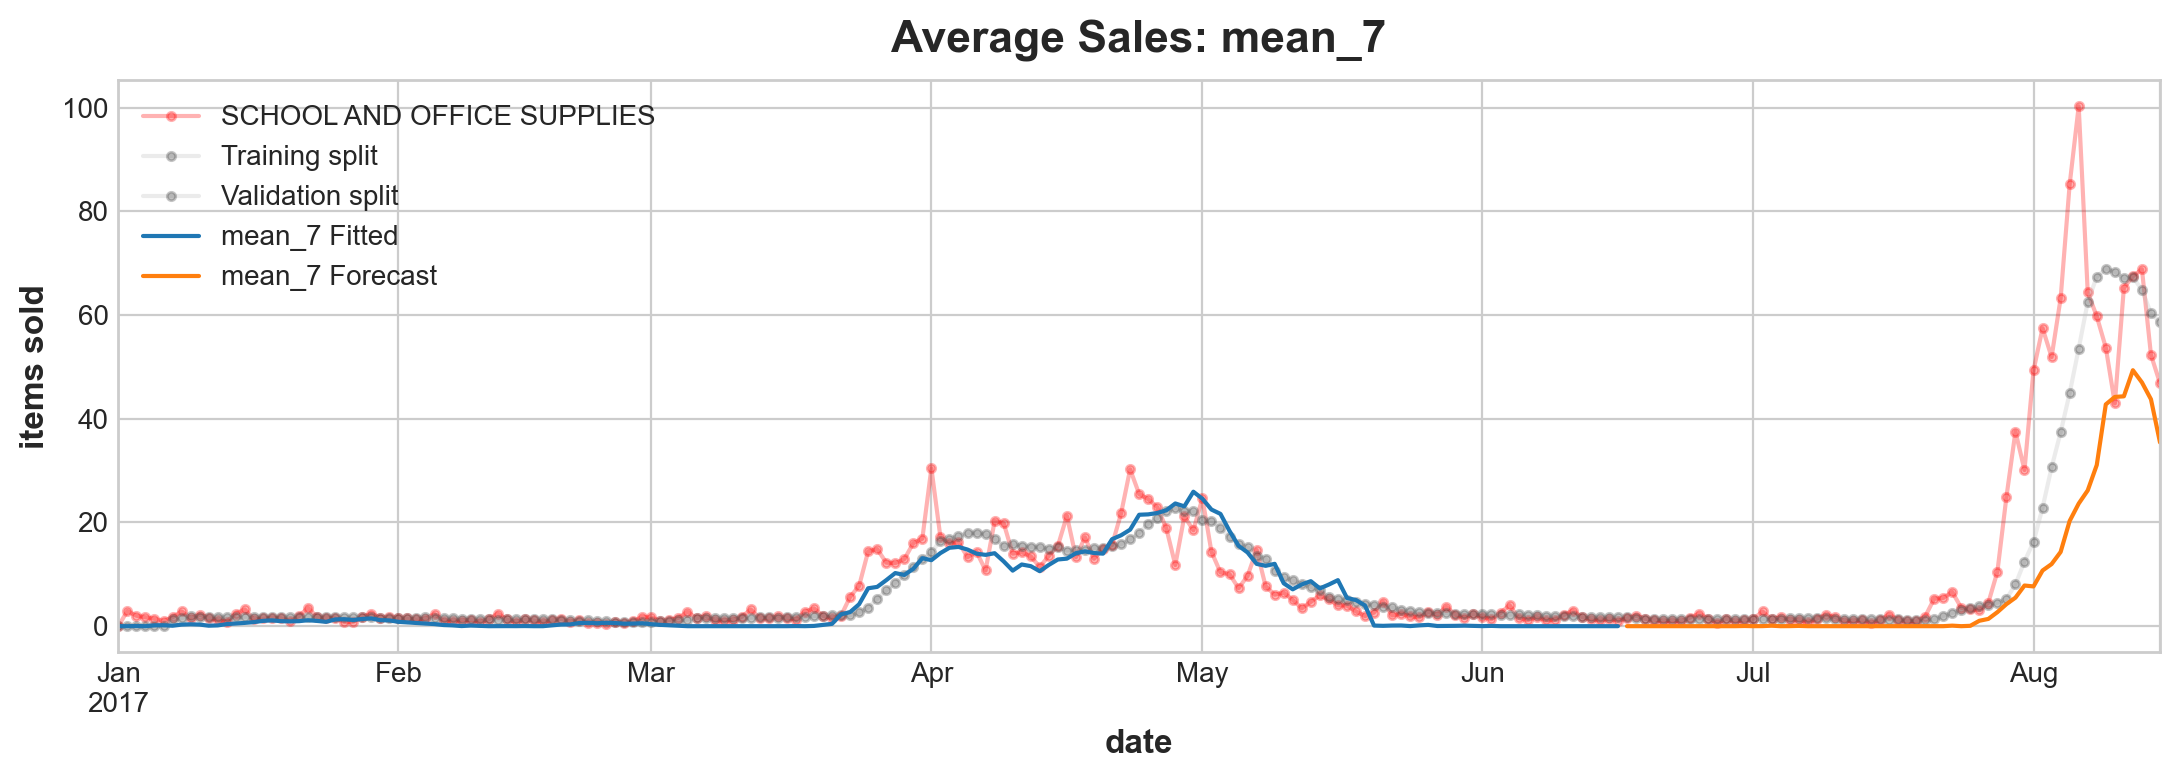

In [14]:
# use iloc to select series from dataframe
plot_stat_feature(X, mean_7.iloc[:,0], label='mean_7')

median_14 Training RMSE: 2.19806
median_14 Validation RMSE: 12.67712
median_14 Training RMSLE: 0.71729
median_14 Validation RMSLE: 0.89914


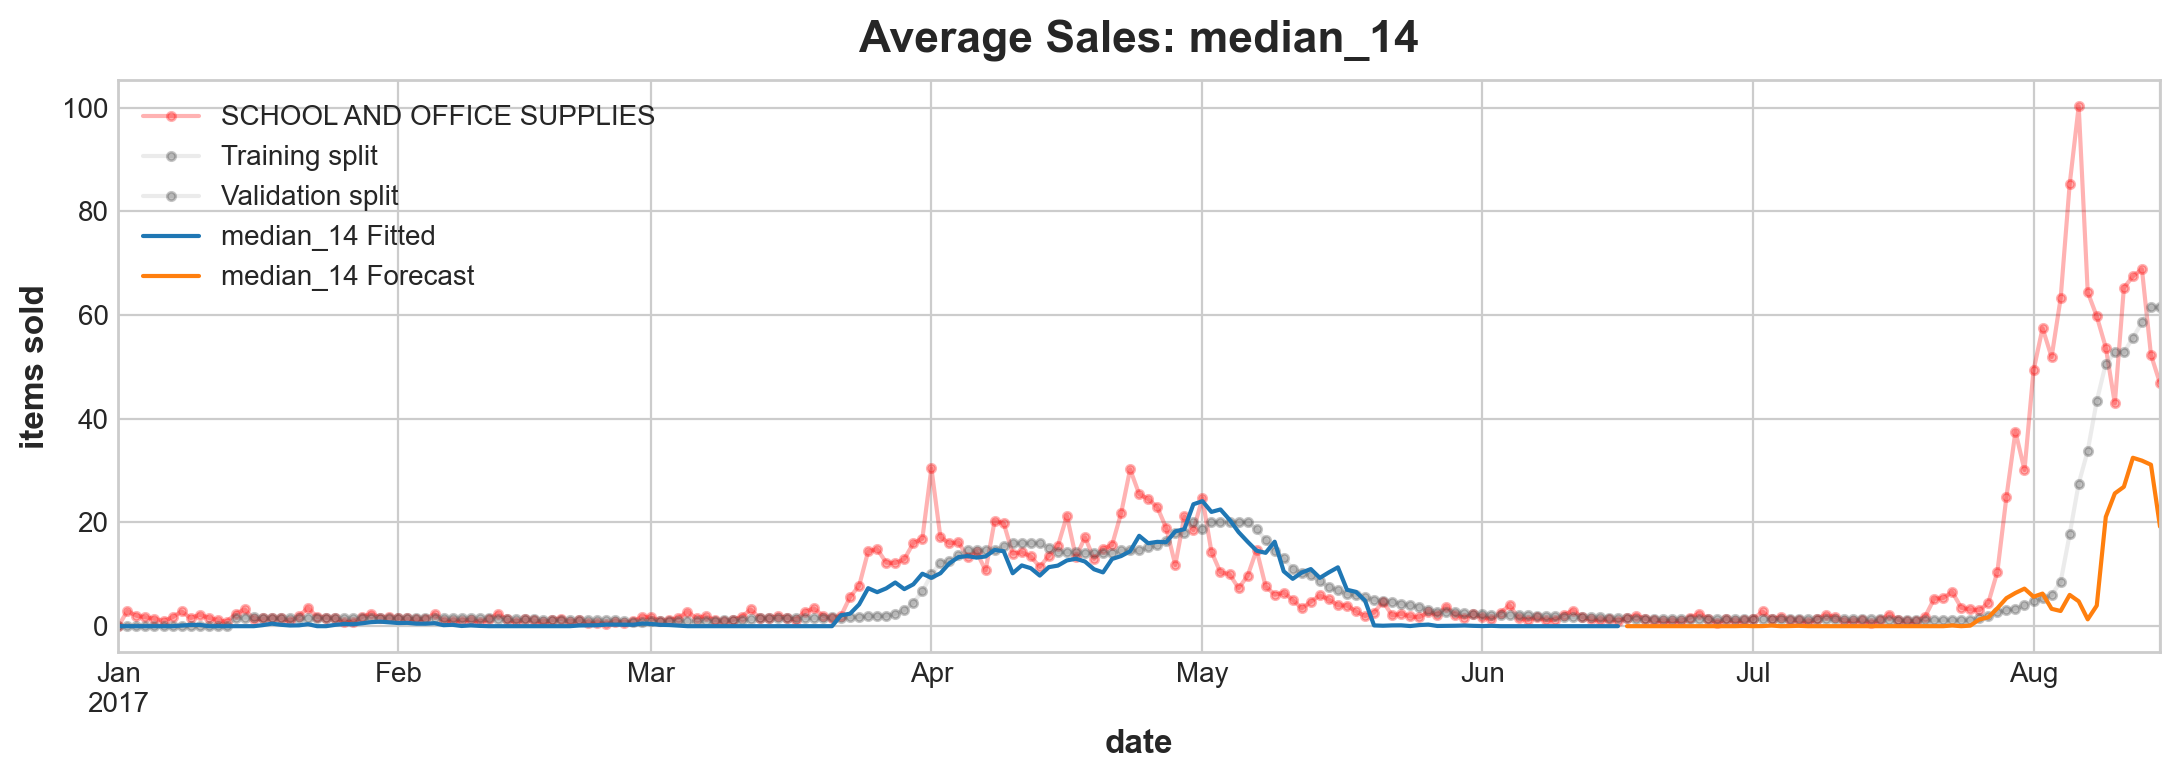

In [15]:
# use iloc to select series from dataframe
plot_stat_feature(X, median_14.iloc[:,0], label='median_14')

std_7 Training RMSE: 0.97700
std_7 Validation RMSE: 5.84126
std_7 Training RMSLE: 0.41538
std_7 Validation RMSLE: 0.71158


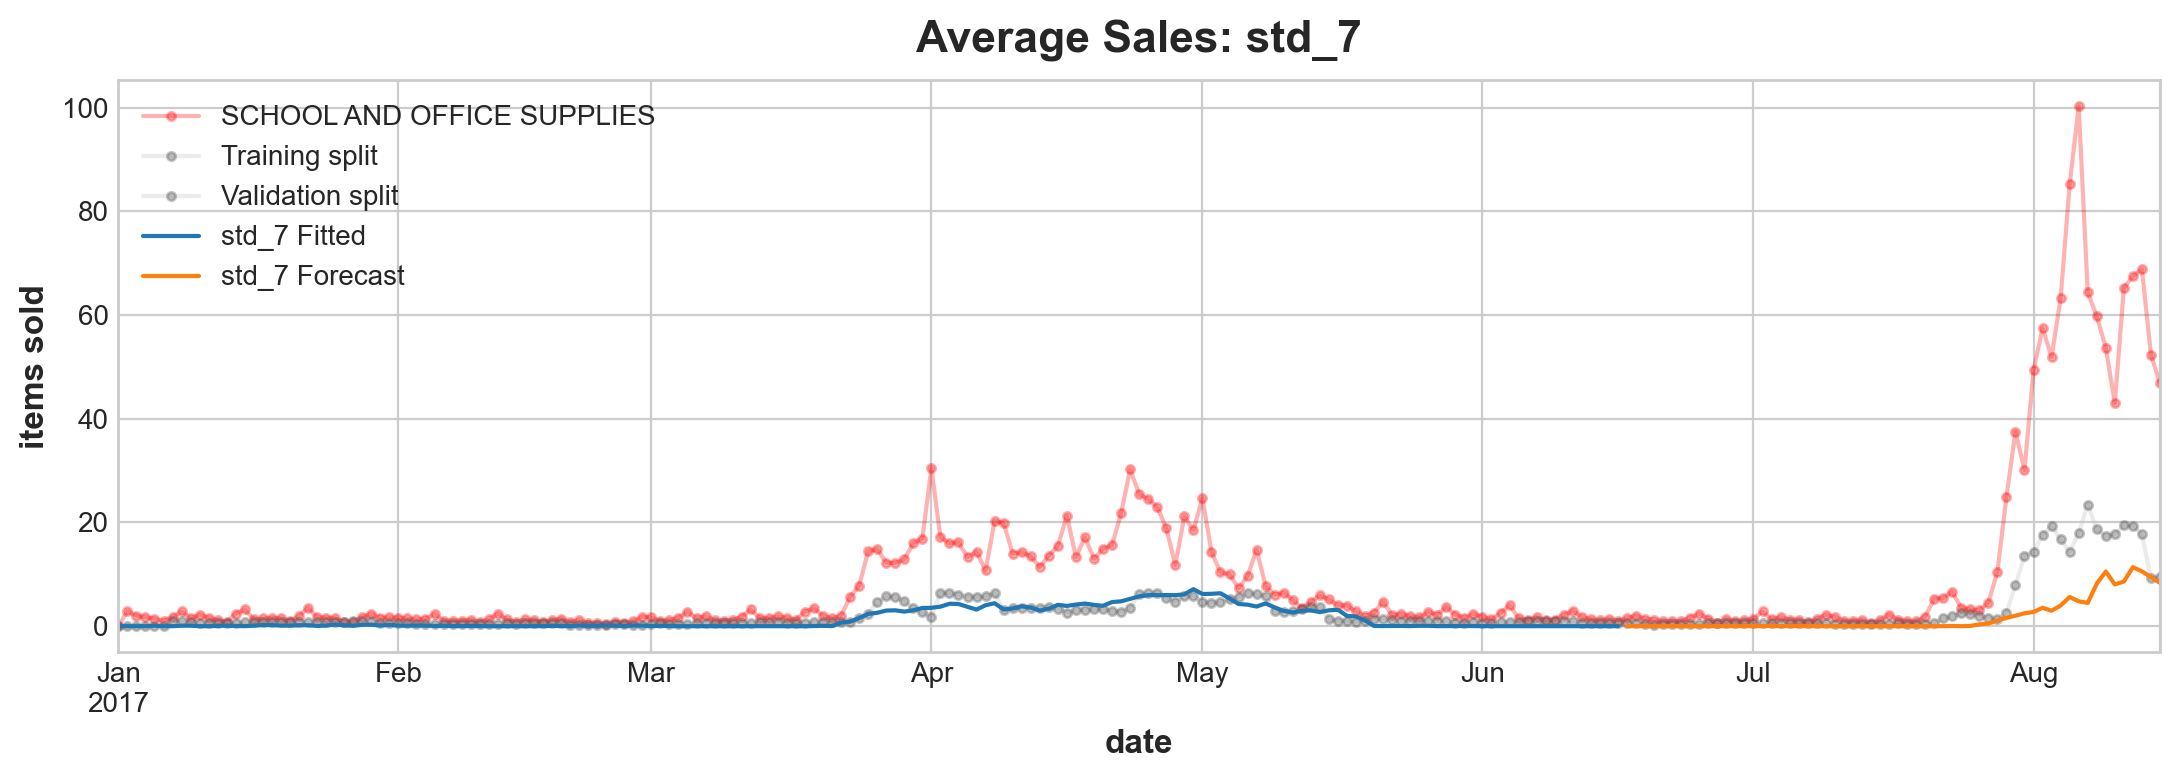

In [16]:
# use iloc to select series from dataframe
plot_stat_feature(X, std_7.iloc[:,0], label='std_7')

promo_7 Training RMSE: 0.53773
promo_7 Validation RMSE: 3.93140
promo_7 Training RMSLE: 0.12951
promo_7 Validation RMSLE: 0.65938


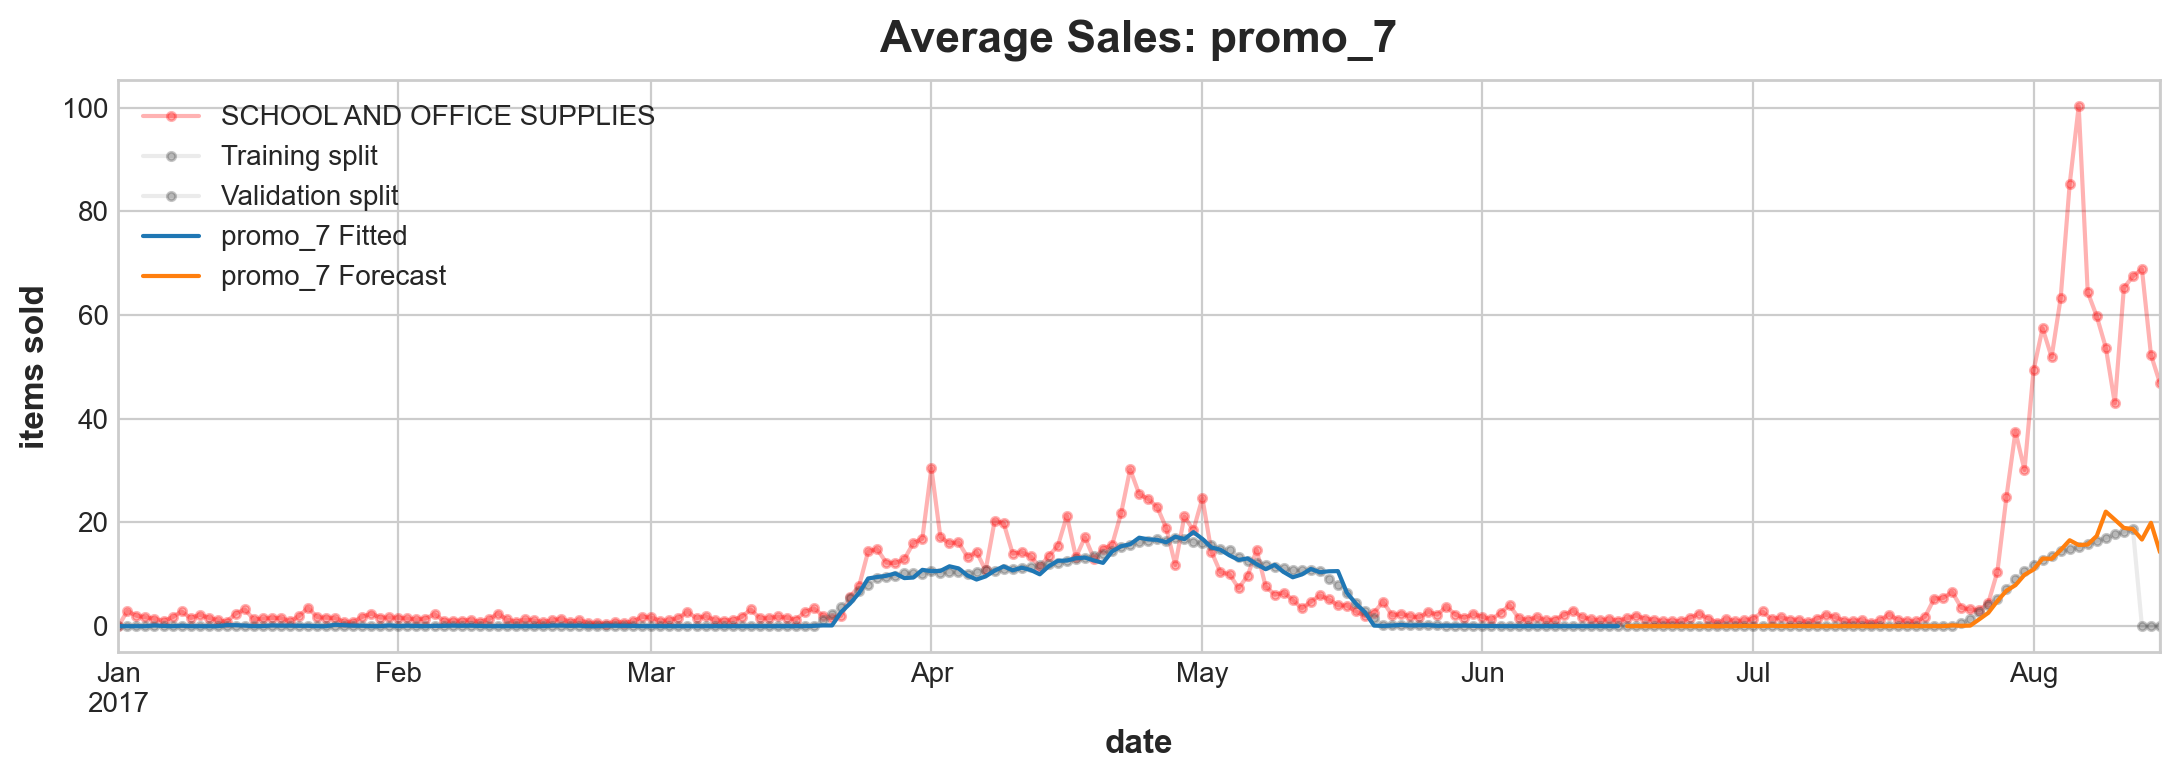

In [17]:
# use iloc to select series from dataframe
plot_stat_feature(X, promo_7.iloc[:,0], label='promo_7')

Note that the RMSLE error score is calculated on the split rather than the full set of features ("SCHOOL AND OFFICE SUPPLIES"). But the full set is plotted (in red) for reference. The best prediction error (using the validation set) was from std_7 with a RMSLE scores of:
- promo_7 Training RMSLE: 0.12951
- promo_7 Validation RMSLE: 0.65938

But these used promotion rather than sales data as the target, so perhaps we should consider std_7 errors as our best:
- std_7 Training RMSLE: 0.41538
- std_7 Validation RMSLE: 0.71158

#### Combine the features to see overall contribution.

combined statistical features Training RMSE: 2.70178
combined statistical features Validation RMSE: 11.67717
combined statistical features Training RMSLE: 0.40661
combined statistical features Validation RMSLE: 0.47556


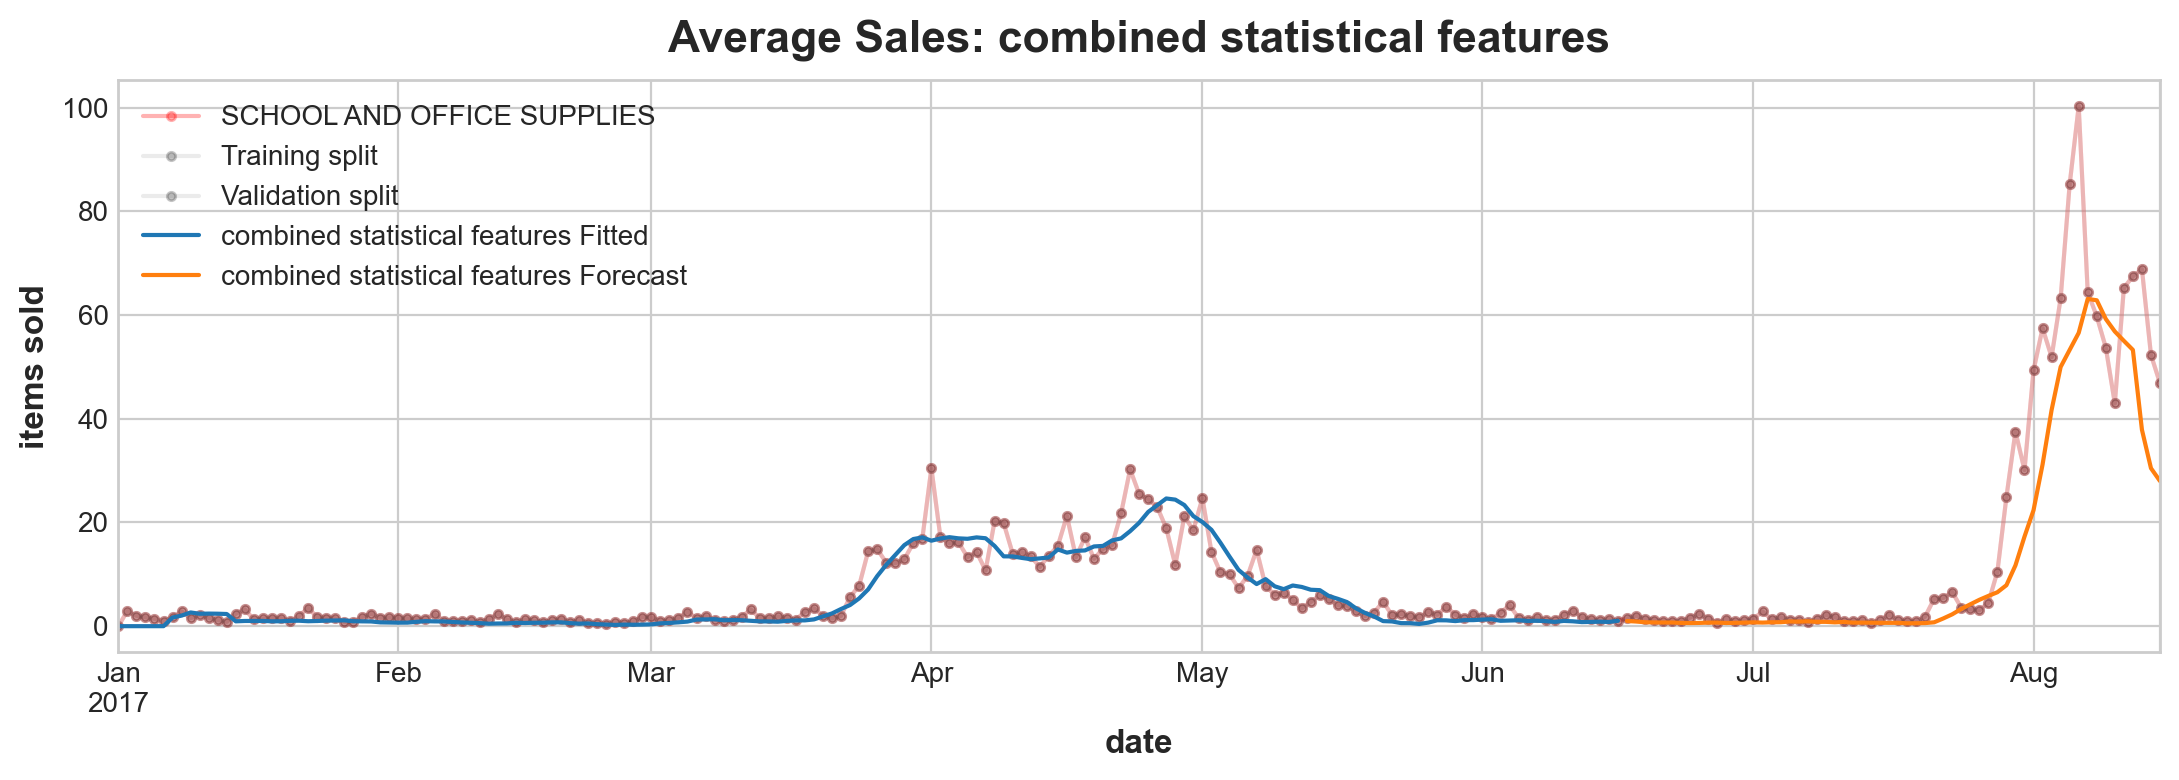

In [18]:
X_combine = pd.concat([
    mean_7,
    median_14,
    std_7,
    promo_7
], axis=1)

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
y, X = y.align(X_combine, join='inner')
plot_stat_feature(X_combine, y, label="combined statistical features")

The combined score beats all individual scores, except for promo_7 - with its caveats.

Now we plot the combined stats minus promo_7 to see if there is an effect.

combined statistical features Training RMSE: 2.86054
combined statistical features Validation RMSE: 10.24816
combined statistical features Training RMSLE: 0.32920
combined statistical features Validation RMSLE: 0.38046


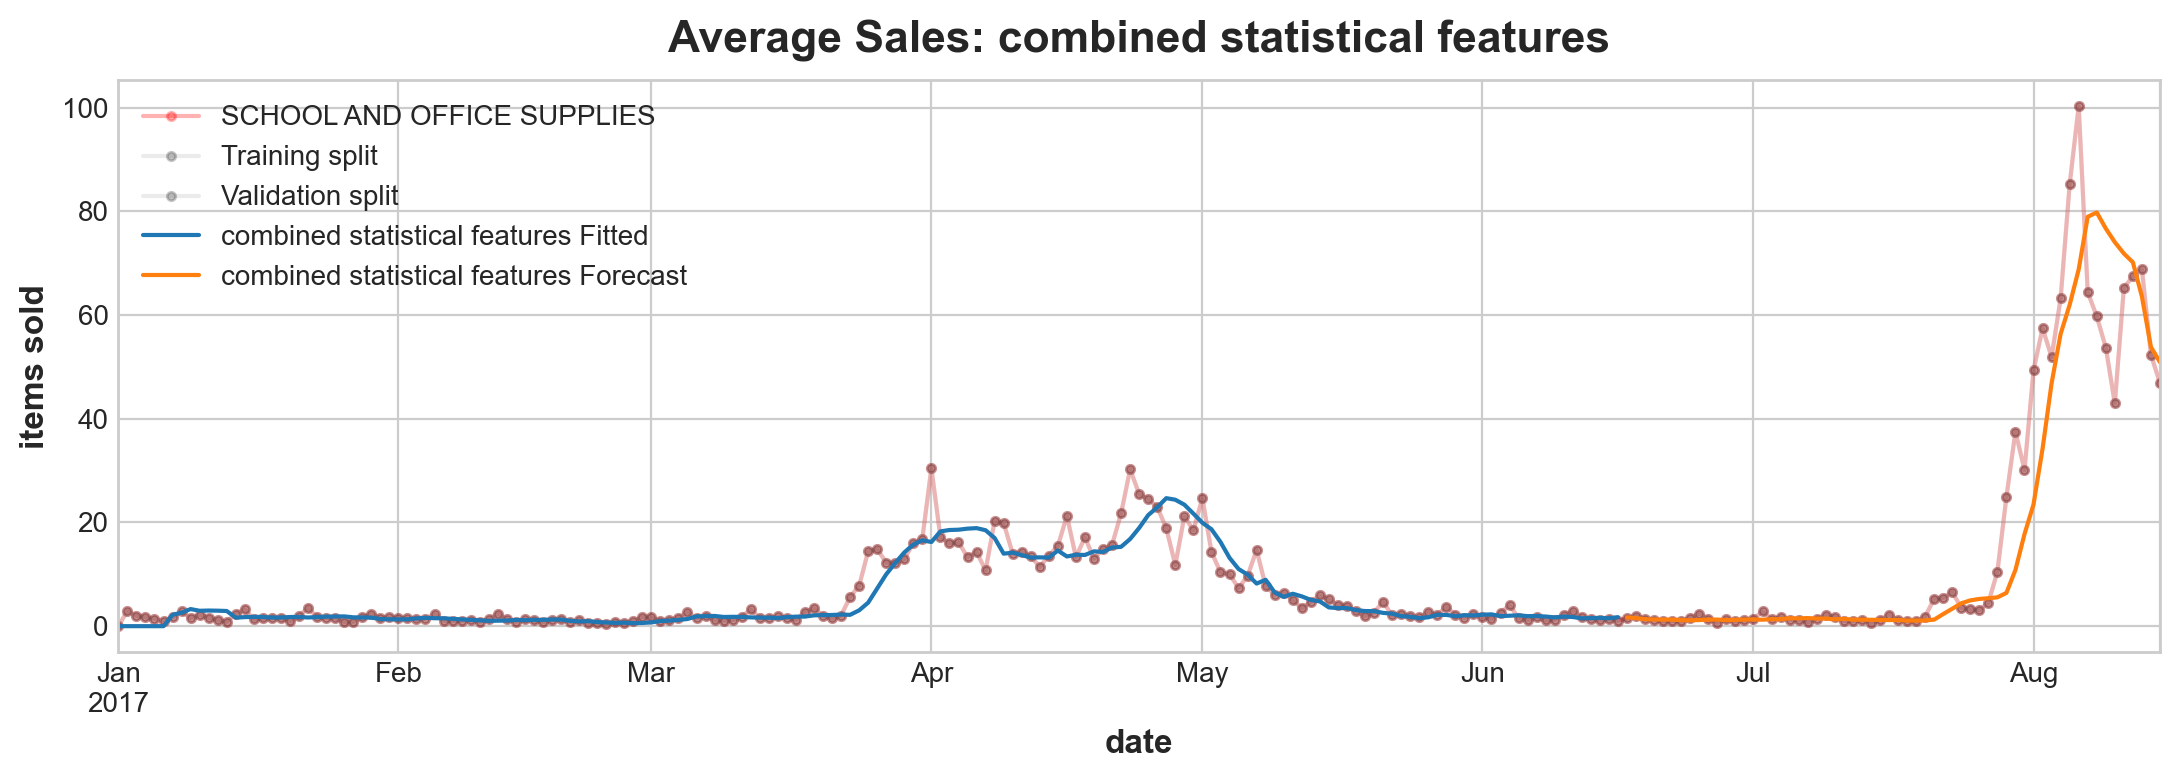

In [19]:
X_combine = pd.concat([
    mean_7,
    median_14,
    std_7
], axis=1)

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
y, X = y.align(X_combine, join='inner')
plot_stat_feature(X_combine, y, label="combined statistical features")

The overall fit is better, but note that the peaks are later in the plot above, as would be expected in dropping our leading indicator.

Finally, lets try using the 7-day rolling average on deseasonalized values, along with the features used above.

combined statistical features Training RMSE: 2.42913
combined statistical features Validation RMSE: 9.70309
combined statistical features Training RMSLE: 0.31175
combined statistical features Validation RMSLE: 0.37768


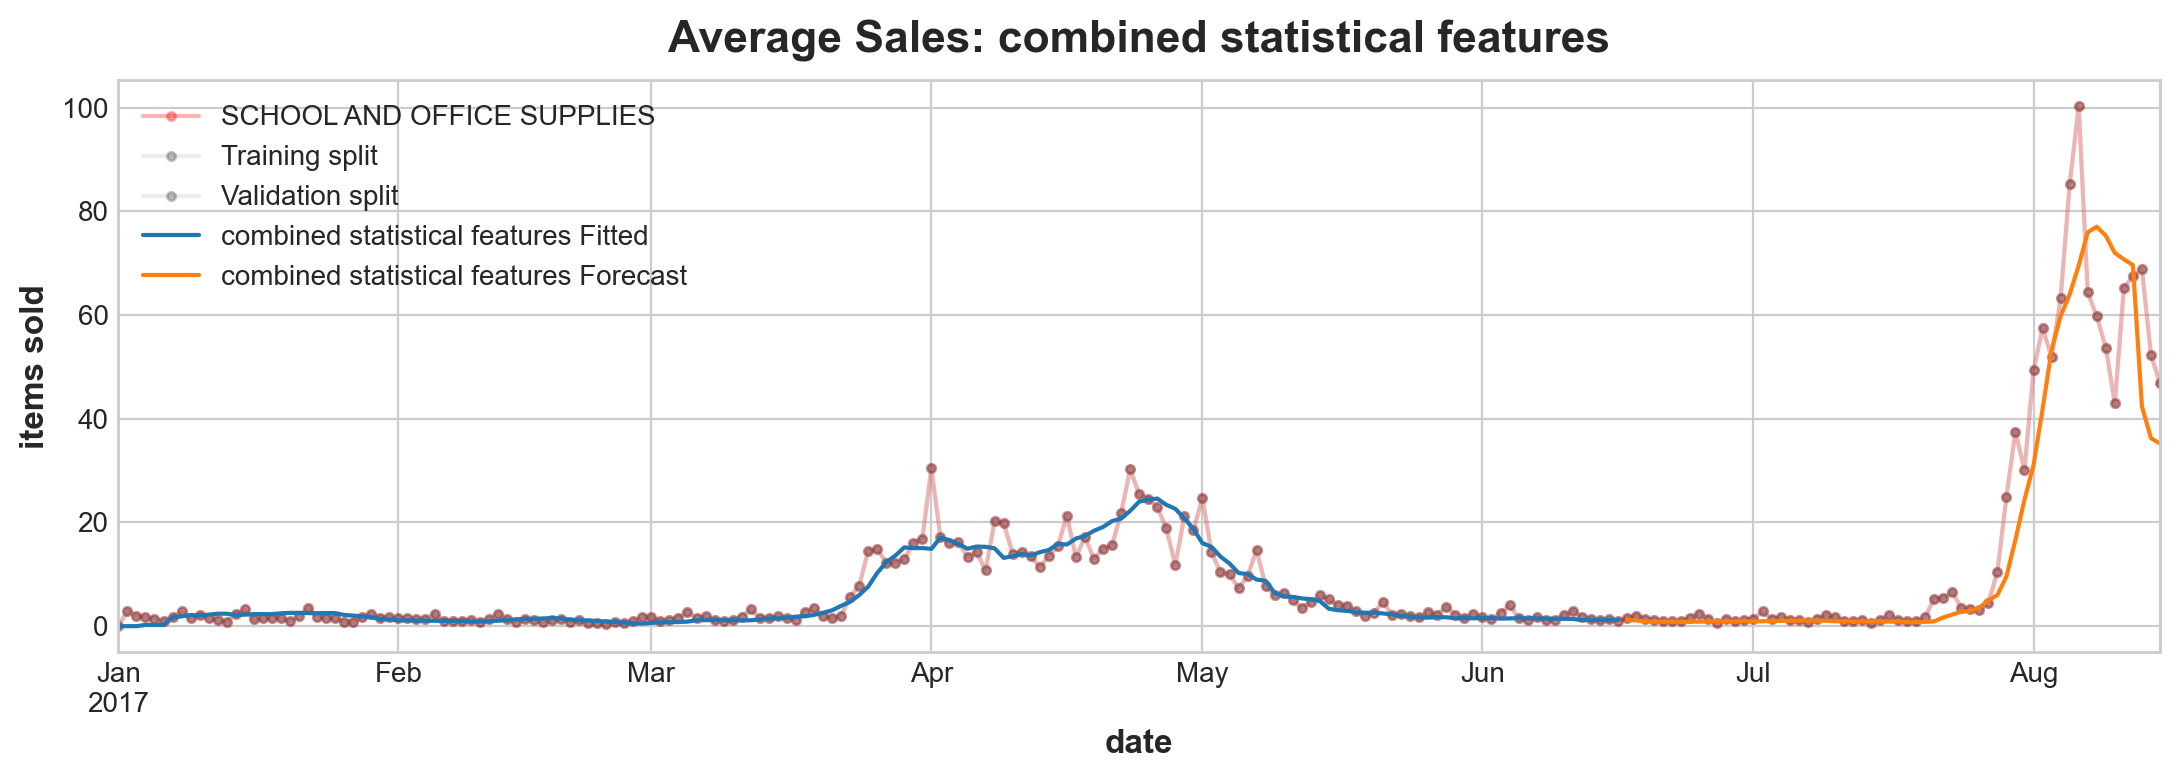

In [36]:
y_ma = y_deseason.rolling(
    window=7,         # 7-day window
    center=True,      # puts the average at the center of the window
).mean().fillna(0)

X_combine = pd.concat([
    y_ma,   
    mean_7,     
    median_14,
    std_7,
], axis=1)

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()
y, X = y.align(X_combine, join='inner')
plot_stat_feature(X_combine, y, label="combined statistical features")

The fit above is superior to the other models in minimizing error.

Check out the Pandas [`Window` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/window.html) for more statistics you can compute. Also try "exponential weighted" windows by using `ewm` in place of `rolling`; exponential decay is often a more realistic representation of how effects propagate over time.

# Keep Going #

[**Create hybrid forecasters**](https://www.kaggle.com/ryanholbrook/hybrid-models) and combine the strengths of two machine learning algorithms.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*